In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210512'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '오피스텔'
house_df = data_prep(target_house, '매매')
print(house_df.shape)
house_df.head()

16it [00:00, 34.25it/s]


(179498, 11)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(177242, 19)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '강동구'
target_dong = '천호동'
target_purpose = '일반상업'
target_building_age = 5
target_period = 18 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(151, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
163016,서울특별시 강동구 천호동 169-9,성안로25길 29,다성 이즈빌,28.40,18000,4,2016.0,4.0,2020-10-05,633.802817,5.0,대,145.0,준주거지역,지정되지않음,주거기타,평지,세로장방,세로각지(가),강동구,천호동
163017,서울특별시 강동구 천호동 169-9,성안로25길 29,다성 이즈빌,24.19,20000,10,2016.0,4.0,2020-12-18,826.787929,5.0,대,145.0,준주거지역,지정되지않음,주거기타,평지,세로장방,세로각지(가),강동구,천호동
163018,서울특별시 강동구 천호동 169-9,성안로25길 29,다성 이즈빌,34.81,21500,5,2016.0,5.0,2021-01-26,617.638610,5.0,대,145.0,준주거지역,지정되지않음,주거기타,평지,세로장방,세로각지(가),강동구,천호동
165969,서울특별시 강동구 천호동 167-102,성안로25길 64,다성 이즈빌,13.97,10500,2,2017.0,3.0,2020-09-14,751.610594,4.0,대,228.0,준주거지역,지정되지않음,주거기타,완경사,세로장방,세로각지(가),강동구,천호동
165976,서울특별시 강동구 천호동 167-2,성안로25길 54,다성이즈빌,20.92,12000,5,2016.0,4.0,2020-09-14,573.613767,5.0,대,284.0,준주거지역,지정되지않음,주상용,완경사,삼각형,세로각지(가),강동구,천호동


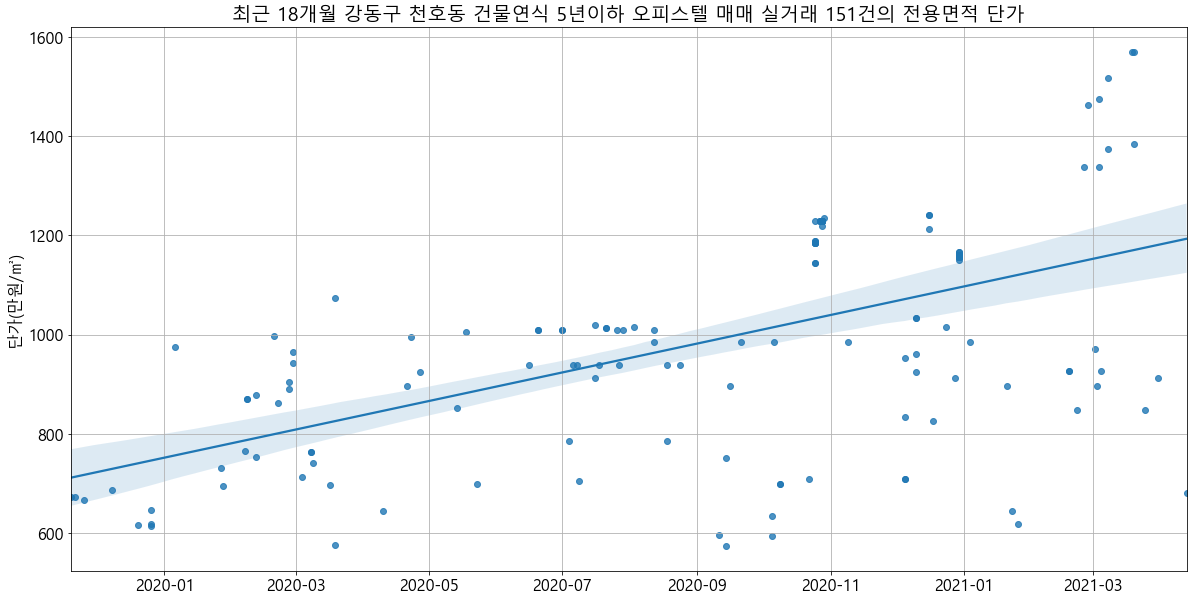

In [14]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/전체_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [15]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1517, 21)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
15462,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8500,7,2004.0,2.0,2006-01-11,270.442253,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동
15463,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8800,10,2004.0,2.0,2006-01-17,279.987273,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동
15464,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8800,14,2004.0,2.0,2006-02-27,279.987273,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동
15465,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8000,6,2004.0,2.0,2006-03-01,254.533885,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동
15466,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8500,12,2004.0,2.0,2006-05-03,270.442253,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동


In [16]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]
filenames

['지역별_연립다세대_실거래가격지수_200601_202102.xlsx']

In [17]:
sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])
print(sales_idx_df.shape)
sales_idx_df.head()

(1, 365)


지 역 2006년 01월     2006년 02월       2006년 03월       2006년 04월  \
  Unnamed: 0_level_1        지수 변동률        지수   변동률        지수   변동률        지수   
0                 서울    50.174   -    49.868 -0.61    51.623  3.52    53.023   

        2006년 05월       2006년 06월       2006년 07월       2006년 08월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.71    53.471  0.84    53.541  0.13    55.004  2.73    57.288  4.15   

  2006년 09월       2006년 10월       2006년 11월       2006년 12월      2007년 01월  \
         지수   변동률        지수   변동률        지수   변동률        지수  변동률        지수   
0    59.279  3.48    62.222  4.96    64.449  3.58    65.672  1.9    67.433   

        2007년 02월       2007년 03월       2007년 04월       2007년 05월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.68    67.316 -0.17    68.825  2.24    70.773  2.83    71.227  0.64   

  2007년 06월       2007년 07월       2007년 08월       2007년 09월       2007년 10월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    73.664  3.42    75.501  2.49    76.363  1.14    77.716  1.77    80.412   

        2007년 11월       2007년 12월       2008년 01월       2008년 02월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  3.47    81.322  1.13    82.895  1.93    85.315  2.92    86.909  1.87   

  2008년 03월       2008년 04월       2008년 05월       2008년 06월      2008년 07월  \
         지수   변동률        지수   변동률        지수   변동률        지수  변동률        지수   
0    91.072  4.79    94.429  3.69    97.021  2.74    97.898  0.9    96.642   

        2008년 08월       2008년 09월       2008년 10월       2008년 11월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -1.28    95.315 -1.37    94.819 -0.52    91.804 -3.18    87.269 -4.94   

  2008년 12월       2009년 01월       2009년 02월       2009년 03월       2009년 04월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    84.235 -3.48    84.433  0.23    85.689  1.49    86.418  0.85    88.165   

        2009년 05월       2009년 06월       2009년 07월       2009년 08월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  2.02    90.322  2.45    90.921  0.66    92.781  2.05    94.755  2.13   

  2009년 09월       2009년 10월       2009년 11월       2009년 12월       2010년 01월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    96.235  1.56    95.553 -0.71    94.461 -1.14    94.582  0.13    96.148   

        2010년 02월       2010년 03월       2010년 04월       2010년 05월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0  1.66     95.87 -0.29    95.305 -0.59    94.813 -0.52    94.425 -0.41   

  2010년 06월       2010년 07월       2010년 08월       2010년 09월       2010년 10월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    92.574 -1.96    91.908 -0.72    91.419 -0.53    91.379 -0.04    90.753   

        2010년 11월       2010년 12월       2011년 01월       2011년 02월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -0.69    91.374  0.68    91.589  0.24     91.95  0.39    92.705  0.82   

  2011년 03월       2011년 04월       2011년 05월       2011년 06월       2011년 07월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    92.885  0.19     92.35 -0.58    92.618  0.29    91.888 -0.79    91.628   

        2011년 08월       2011년 09월       2011년 10월       2011년 11월        \
    변동률        지수   변동률        지수   변동률        지수   변동률        지수   변동률   
0 -0.28    91.073 -0.61    91.898  0.91    91.392 -0.55    90.653 -0.81   

  2011년 12월       2012년 01월       2012년 02월       2012년 03월       2012년 04월  \
         지수   변동률        지수   변동률        지수   변동률        지수   변동률        지수   
0    89.877 -0.86    90.529  0.73    90.105 -0.47    89.855 -0.28    88.579   

        2012년 05월       2012년 06월       2012년 07월       2012년 08월     

In [18]:
sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

In [19]:
sales_idx_df.columns = sales_idx_cols_list
sales_idx_df.head()

,지 역,2006년 01월_지수,2006년 01월_변동률,2006년 02월_지수,2006년 02월_변동률,2006년 03월_지수,2006년 03월_변동률,2006년 04월_지수,2006년 04월_변동률,2006년 05월_지수,2006년 05월_변동률,2006년 06월_지수,2006년 06월_변동률,2006년 07월_지수,2006년 07월_변동률,2006년 08월_지수,2006년 08월_변동률,2006년 09월_지수,2006년 09월_변동률,2006년 10월_지수,2006년 10월_변동률,2006년 11월_지수,2006년 11월_변동률,2006년 12월_지수,2006년 12월_변동률,2007년 01월_지수,2007년 01월_변동률,2007년 02월_지수,2007년 02월_변동률,2007년 03월_지수,2007년 03월_변동률,2007년 04월_지수,2007년 04월_변동률,2007년 05월_지수,2007년 05월_변동률,2007년 06월_지수,2007년 06월_변동률,2007년 07월_지수,2007년 07월_변동률,2007년 08월_지수,2007년 08월_변동률,2007년 09월_지수,2007년 09월_변동률,2007년 10월_지수,2007년 10월_변동률,2007년 11월_지수,2007년 11월_변동률,2007년 12월_지수,2007년 12월_변동률,2008년 01월_지수,2008년 01월_변동률,2008년 02월_지수,2008년 02월_변동률,2008년 03월_지수,2008년 03월_변동률,2008년 04월_지수,2008년 04월_변동률,2008년 05월_지수,2008년 05월_변동률,2008년 06월_지수,2008년 06월_변동률,2008년 07월_지수,2008년 07월_변동률,2008년 08월_지수,2008년 08월_변동률,2008년 09월_지수,2008년 09월_변동률,2008년 10월_지수,2008년 10월_변동률,2008년 11월_지수,2008년 11월_변동률,2008년 12월_지수,2008년 12월_변동률,2009년 01월_지수,2009년 01월_변동률,2009년 02월_지수,2009년 02월_변동률,2009년 03월_지수,2009년 03월_변동률,2009년 04월_지수,2009년 04월_변동률,2009년 05월_지수,2009년 05월_변동률,2009년 06월_지수,2009년 06월_변동률,2009년 07월_지수,2009년 07월_변동률,2009년 08월_지수,2009년 08월_변동률,2009년 09월_지수,2009년 09월_변동률,2009년 10월_지수,2009년 10월_변동률,2009년 11월_지수,2009년 11월_변동률,2009년 12월_지수,2009년 12월_변동률,2010년 01월_지수,2010년 01월_변동률,2010년 02월_지수,2010년 02월_변동률,2010년 03월_지수,2010년 03월_변동률,2010년 04월_지수,2010년 04월_변동률,2010년 05월_지수,2010년 05월_변동률,2010년 06월_지수,2010년 06월_변동률,2010년 07월_지수,2010년 07월_변동률,2010년 08월_지수,2010년 08월_변동률,2010년 09월_지수,2010년 09월_변동률,2010년 10월_지수,2010년 10월_변동률,2010년 11월_지수,2010년 11월_변동률,2010년 12월_지수,2010년 12월_변동률,2011년 01월_지수,2011년 01월_변동률,2011년 02월_지수,2011년 02월_변동률,2011년 03월_지수,2011년 03월_변동률,2011년 04월_지수,2011년 04월_변동률,2011년 05월_지수,2011년 05월_변동률,2011년 06월_지수,2011년 06월_변동률,2011년 07월_지수,2011년 07월_변동률,2011년 08월_지수,2011년 08월_변동률,2011년 09월_지수,2011년 09월_변동률,2011년 10월_지수,2011년 10월_변동률,2011년 11월_지수,2011년 11월_변동률,2011년 12월_지수,2011년 12월_변동률,2012년 01월_지수,2012년 01월_변동률,2012년 02월_지수,2012년 02월_변동률,2012년 03월_지수,2012년 03월_변동률,2012년 04월_지수,2012년 04월_변동률,2012년 05월_지수,2012년 05월_변동률,2012년 06월_지수,2012년 06월_변동률,2012년 07월_지수,2012년 07월_변동률,2012년 08월_지수,2012년 08월_변동률,2012년 09월_지수,2012년 09월_변동률,2012년 10월_지수,2012년 10월_변동률,2012년 11월_지수,2012년 11월_변동률,2012년 12월_지수,2012년 12월_변동률,2013년 01월_지수,2013년 01월_변동률,2013년 02월_지수,2013년 02월_변동률,2013년 03월_지수,2013년 03월_변동률,2013년 04월_지수,2013년 04월_변동률,2013년 05월_지수,2013년 05월_변동률,2013년 06월_지수,2013년 06월_변동률,2013년 07월_지수,2013년 07월_변동률,2013년 08월_지수,2013년 08월_변동률,2013년 09월_지수,2013년 09월_변동률,2013년 10월_지수,2013년 10월_변동률,2013년 11월_지수,2013년 11월_변동률,2013년 12월_지수,2013년 12월_변동률,2014년 01월_지수,2014년 01월_변동률,2014년 02월_지수,2014년 02월_변동률,2014년 03월_지수,2014년 03월_변동률,2014년 04월_지수,2014년 04월_변동률,2014년 05월_지수,2014년 05월_변동률,2014년 06월_지수,2014년 06월_변동률,2014년 07월_지수,2014년 07월_변동률,2014년 08월_지수,2014년 08월_변동률,2014년 09월_지수,2014년 09월_변동률,2014년 10월_지수,2014년 10월_변동률,2014년 11월_지수,2014년 11월_변동률,2014년 12월_지수,2014년 12월_변동률,2015년 01월_지수,2015년 01월_변동률,2015년 02월_지수,2015년 02월_변동률,2015년 03월_지수,2015년 03월_변동률,2015년 04월_지수,2015년 04월_변동률,2015년 05월_지수,2015년 05월_변동률,2015년 06월_지수,2015년 06월_변동률,2015년 07월_지수,2015년 07월_변동률,2015년 08월_지수,2015년 08월_변동률,2015년 09월_지수,2015년 09월_변동률,2015년 10월_지수,2015년 10월_변동률,2015년 11월_지수,2015년 11월_변동률,2015년 12월_지수,2015년 12월_변동률,2016년 01월_지수,2016년 01월_변동률,2016년 02월_지수,2016년 02월_변동률,2016년 03월_지수,2016년 03월_변동률,2016년 04월_지수,2016년 04월_변동률,2016년 05월_지수,2016년 05월_변동률,2016년 06월_지수,2016년 06월_변동률,2016년 07월_지수,2016년 07월_변동률,2016년 08월_지수,2016년 08월_변동률,2016년 09월_지수,2016년 09월_변동률,2016년 10월_지수,2016년 10월_변동률,2016년 11월_지수,2016년 11월_변동률,2016년 12월_지수,2016년 12월_변동률,2017년 01월_지수,2017년 01월_변동률,2017년 02월_지수,2017년 02월_변동률,2017년 03월_지수,2017년 03월_변동률,2017년 04월_지수,2017년 04월_변동률,2017년 05월_지수,2017년 05월_변동률,2017년 06월_지수,2017년 06월_변동률,2017년 07월_지수,2017년 07월_변동률,2017년 08월_지수,2017년 08월_변동률,2017년 09월_지수,2017년 09월_변동률,2017년 10월_지수,2017년 10월_변동률,2017년 11월_지수,2017년 11월_변동률,2017년 12월_지수,2017년 12월_변동률,2018년 01월_지수,2018년 01월_변동률,2018년 02월_지수,2018년 02월_변동률,2018년 03월_지수,2018년 03월_변동률,2018년 04월_지수,2018년 04월_변동률

In [20]:
last_idx = sales_idx_df.iloc[0,-2]
last_idx

124.636

In [21]:
last_date = sales_idx_df.columns[-1].split('_')[0]
last_date

'2021년 02월'

In [22]:
last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
last_date

'2021-02-01'

In [23]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [24]:
target_upper_limit_df = target_df2[target_df2['계약날짜'] <= pd.to_datetime(last_date)]

In [25]:
target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)

In [26]:
target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx

In [27]:
target_upper_limit_df.head()

,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,계약날짜_실거래지수,지수적용단가
15462,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8500,7,2004.0,2.0,2006-01-11,270.442253,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,50.174,671.798952
15463,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8800,10,2004.0,2.0,2006-01-17,279.987273,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,50.174,695.509503
15464,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8800,14,2004.0,2.0,2006-02-27,279.987273,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,49.868,699.777288
15465,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8000,6,2004.0,2.0,2006-03-01,254.533885,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,51.623,614.533934
15466,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,8500,12,2004.0,2.0,2006-05-03,270.442253,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,53.471,630.376103


In [28]:
target_df2['지수적용단가'] = target_df2['단가(만원/㎡)']

In [29]:
target_df2.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']

In [30]:
target_df2['평가날짜'] = target_df2['계약날짜']

In [31]:
target_df2.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '15')

<AxesSubplot:title={'center':'강동구 천호동 계약날짜기준 건물연식 5년이하 오피스텔 매매 실거래 1517건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

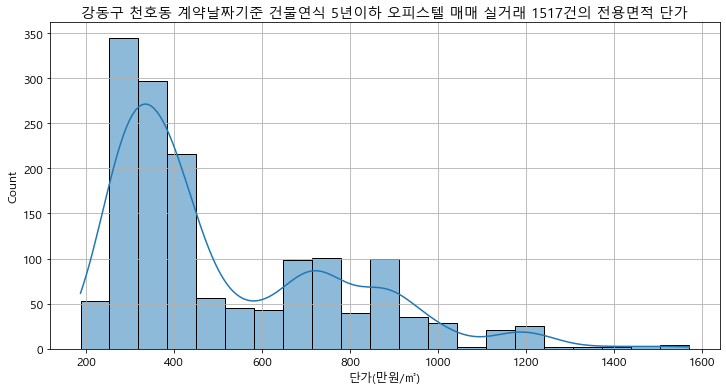

In [32]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [33]:
concat_df = pd.concat([target_df2])

In [34]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [35]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [36]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(197, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,25.43,12000,14,2004.0,5.0,2009-09-11,471.883602,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,611.146512,2021-02-15,400.591628,576.545172
1,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,31.43,13000,14,2004.0,5.0,2009-11-17,413.617563,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,545.745213,2021-02-15,400.591628,576.545172
2,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,34.78,11000,15,2004.0,3.0,2007-03-20,316.273721,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,572.743791,2021-02-15,400.591628,576.545172
3,서울특별시 강동구 천호동 161-17,진황도로 66,정암하이빌,23.12,8000,9,2003.0,5.0,2008-10-01,346.020761,18.0,대,185.0,일반상업지역,지정되지않음,업무용,평지,사다리형,중로한면,강동구,천호동,469.768677,2021-02-15,346.020761,469.768677
4,서울특별시 강동구 천호동 163-14,진황도로31길 5,우정에쉐르,71.28,15000,2,2004.0,3.0,2007-04-17,210.437710,17.0,대,848.0,일반상업지역,지정되지않음,주상용,평지,사다리형,중로각지,강동구,천호동,370.594923,2021-02-15,203.868907,376.073856


In [37]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(50, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
2,서울특별시 강동구 천호동 155-5,성안로 155,강동역두산위브센티움,34.78,11000,15,2004.0,3.0,2007-03-20,316.273721,17.0,대,2640.0,일반상업지역,지정되지않음,상업기타,평지,부정형,중로각지,강동구,천호동,572.743791,2021-02-15,400.591628,576.545172
3,서울특별시 강동구 천호동 161-17,진황도로 66,정암하이빌,23.12,8000,9,2003.0,5.0,2008-10-01,346.020761,18.0,대,185.0,일반상업지역,지정되지않음,업무용,평지,사다리형,중로한면,강동구,천호동,469.768677,2021-02-15,346.020761,469.768677
5,서울특별시 강동구 천호동 163-14,진황도로31길 5,우정에쉐르,96.30,19000,2,2004.0,2.0,2006-11-26,197.300104,17.0,대,848.0,일반상업지역,지정되지않음,주상용,평지,사다리형,중로각지,강동구,천호동,381.552790,2021-02-15,203.868907,376.073856
10,서울특별시 강동구 천호동 163-15,진황도로33길 11,S.I 팰리스,43.84,32500,2,2020.0,0.0,2020-03-09,741.332117,1.0,대,149.0,준주거지역,지정되지않음,주거기타,평지,가로장방,세로한면(가),강동구,천호동,831.877822,2021-02-15,766.792331,857.533357
13,서울특별시 강동구 천호동 163-21,,성우스타팰리스,46.58,28800,2,2019.0,0.0,2019-12-26,618.291112,2.0,대,407.0,준주거지역,지정되지않음,주거기타,평지,사다리형,세로한면(가),강동구,천호동,696.933501,2021-02-15,618.533947,681.395610
16,서울특별시 강동구 천호동 163-30,진황도로31길 14-6,성우스타팰리스,38.89,26500,4,2017.0,4.0,2021-04-13,681.409103,4.0,대,142.0,준주거지역,지정되지않음,주거기타,평지,사다리형,세로한면(가),강동구,천호동,681.409103,2021-04-13,641.192333,649.944167
23,서울특별시 강동구 천호동 163-7,진황도로 53-3,현일 디와이디,26.93,25400,11,2019.0,1.0,2020-02-29,943.186038,2.0,대,175.0,일반상업지역,준주거지역,상업기타,평지,자루형,중로한면,강동구,천호동,1049.888228,2021-02-15,955.251158,1080.547580
25,서울특별시 강동구 천호동 164-70,천호대로167길 26,하이브2,23.40,15500,5,2013.0,5.0,2018-04-21,662.393162,8.0,대,462.0,일반상업지역,지정되지않음,상업기타,평지,사다리형,중로한면,강동구,천호동,808.362226,2021-02-15,681.438127,814.358379
35,서울특별시 강동구 천호동 165-1,진황도로29길 8,선경오피스텔,35.34,8900,7,2002.0,5.0,2007-02-20,251.839276,19.0,대,433.0,준주거지역,지정되지않음,주상용,완경사,부정형,세로한면(가),강동구,천호동,466.282013,2021-02-15,254.098498,470.464976
39,서울특별시 강동구 천호동 165-5,진황도로 45,다성 이즈빌,21.60,29900,2,2020.0,1.0,2021-03-20,1384.259259,1.0,대,99.0,준주거지역,지정되지않음,다세대,평지,자루형,중로한면,강동구,천호동,1384.259259,2021-03-20,1441.646713,1441.646713


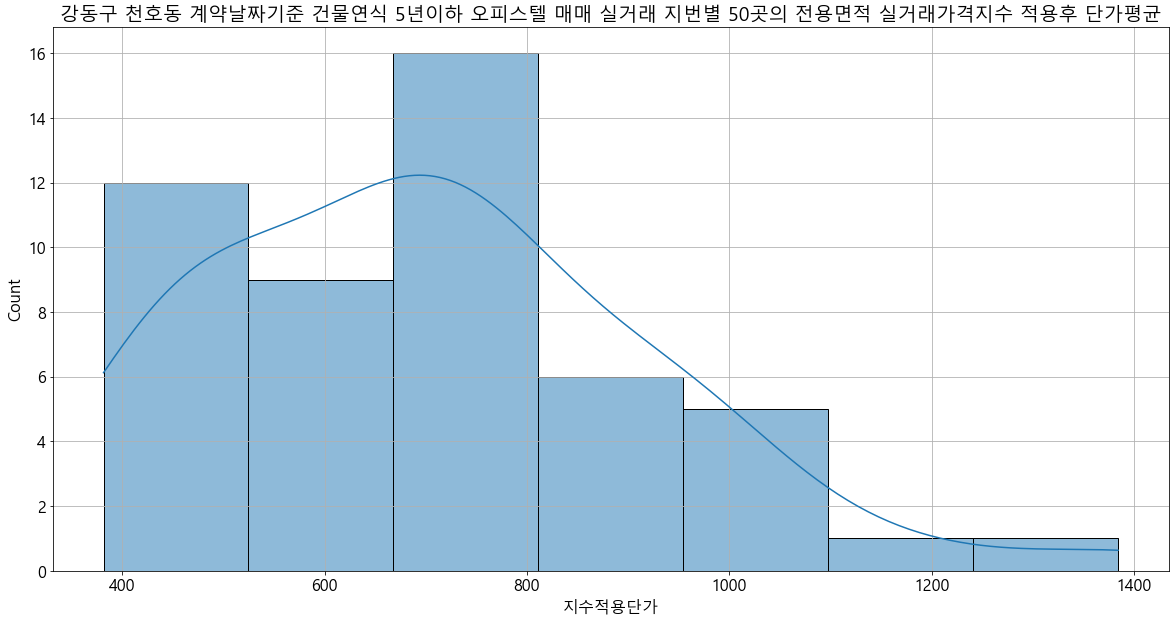

In [38]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [39]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [40]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '계약날짜', '단가평균', '평가날짜', '지수적용단가평균', '용도지역명1']]
concat_last_df

,지번주소,건물(단지)명,건축년도,계약날짜,단가평균,평가날짜,지수적용단가평균,용도지역명1
0,서울특별시 강동구 천호동 155-5,강동역두산위브센티움,2004.0,2007-03-20,400.591628,2021-02-15,576.545172,일반상업지역
1,서울특별시 강동구 천호동 161-17,정암하이빌,2003.0,2008-10-01,346.020761,2021-02-15,469.768677,일반상업지역
2,서울특별시 강동구 천호동 163-14,우정에쉐르,2004.0,2006-11-26,203.868907,2021-02-15,376.073856,일반상업지역
3,서울특별시 강동구 천호동 163-15,S.I 팰리스,2020.0,2020-03-09,766.792331,2021-02-15,857.533357,준주거지역
4,서울특별시 강동구 천호동 163-21,성우스타팰리스,2019.0,2019-12-26,618.533947,2021-02-15,681.395610,준주거지역
5,서울특별시 강동구 천호동 163-30,성우스타팰리스,2017.0,2021-04-13,641.192333,2021-04-13,649.944167,준주거지역
6,서울특별시 강동구 천호동 163-7,현일 디와이디,2019.0,2020-02-29,955.251158,2021-02-15,1080.547580,일반상업지역
7,서울특별시 강동구 천호동 164-70,하이브2,2013.0,2018-04-21,681.438127,2021-02-15,814.358379,일반상업지역
8,서울특별시 강동구 천호동 165-1,선경오피스텔,2002.0,2007-02-20,254.098498,2021-02-15,470.464976,준주거지역
9,서울특별시 강동구 천호동 165-5,다성 이즈빌,2020.0,2021-03-20,1441.646713,2021-03-20,1441.646713,준주거지역


In [41]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)